# Introduction

**Welcome to team JAKK's final notebook!**
In this project, we wanted to find the BEST neighborhood in Pittsburgh. To do that, we used a metric based on one of America's biggest symbols of freedom: the vehicle.

In our project, we looked at 4 different datasets for 4 different submetrics:
* Police Incidents
* Traffic count
* Bridges
* Speed Hump

All of these relate to vehicular transportation in some shape or form, which we will explain later. We thought of this metric because when a neighborhood is easily able to be traveled through, then that means that it is stress free and leisurely. Additionally, there was a lot of data on metrics that related to vehicular transportation. 

Another metric that we considered pursuing would be a neighborhood's orientation towards nature, which includes parks and greenspaces, but the datasets didn't work out as well for that one.

# The Metric

Our Metric: **Feasabiltiy of Vehicles!**
Our Datasets (plus an explaination):
* Police Incidents (25%)
    * The higher the amount of police incidents, the harder it might be to travel through an area. Additionally, the more likely that your car will be robbed.
* Traffic count (50%)
    * The higher the traffic count, the harder it will be to traverse through a neighborhood. Additionally, more traffic will indicate a noisier, more congested neighborhood.
* Bridges (15%)
    * Pittsburgh is known for its Bridges. Bridges are nice looking. Bridges allow vehicles to go over water channels. More bridges are good.
* Speed Hump (10%)
    * Speed humps could be an indicator of a residential area. More speed humps impede the traffic flow. We want smooth sailling, so less speed humps is better!

Overall, this metric uses the lens of the vehicle to see Pittsburgh through the eyes of its transportation. By doing this, it includes scenery through bridges, congestion through traffic, safety through police incidents, and the ability to go fast through speed humps. 

# The Best Neighborhood

In [1]:
import pandas as pd 
import numpy as np
import math

# DATAFRAME FOR BRIDGES
bridges = pd.read_csv("bridges.csv", index_col = "id")
neighborhood = dict()
for index, row in bridges.iterrows():
    if row["neighborhood"] in neighborhood:
        neighborhood[row["neighborhood"]] = neighborhood[row["neighborhood"]] + 1
    else:
        neighborhood[row["neighborhood"]] = 1
bridgescount = pd.DataFrame(list(neighborhood.items()), columns = ['neighborhood', '# of bridges'])
bridgescount_sorted = bridgescount.sort_values("# of bridges", ascending = False)

In [2]:
# DATAFRAME FOR CRIME
policeIncidents = pd.read_csv("CrimeIncidents.csv") ## import data set
main_df = policeIncidents[['INCIDENTNEIGHBORHOOD','OFFENSES']].copy()
main_df = main_df.sort_values('INCIDENTNEIGHBORHOOD')
neighborhood_incidents = main_df.groupby('INCIDENTNEIGHBORHOOD').count().to_dict(orient='dict')['OFFENSES']
neighborhood_incidents_df = pd.DataFrame(list(neighborhood_incidents.items()), columns = ['neighborhood', 'crime incidents'])

In [3]:
# DATAFRAME FOR TRAFFIC
traffic_count_df = pd.read_csv("Traffic_Count.csv", index_col="id") # use the column named _id as the row index
neighborhoodToCarTraffic_df = traffic_count_df[['neighborhood','average_daily_car_traffic']].copy()
neighborhoodToCarTraffic_df = neighborhoodToCarTraffic_df.sort_values('neighborhood')
newDict = {}
for index,row in neighborhoodToCarTraffic_df.iterrows():
    if(newDict.get(row["neighborhood"]) == None):
        if(not math.isnan(row["average_daily_car_traffic"])):
            newDict[row["neighborhood"]] = (row["average_daily_car_traffic"]/1000)
        else:
            newDict[row["neighborhood"]] = 0
    else:
        if(not math.isnan(row["average_daily_car_traffic"])):
            tempQuant = newDict.get(row["neighborhood"])
            tempQuant += (row["average_daily_car_traffic"]/1000)
            newDict[row["neighborhood"]] = tempQuant   
#convert dictionary of neighborhoods to a dataframe
neighborhoodToTraffic = pd.DataFrame(list(newDict.items()), columns = ['neighborhood', 'total traffic (in thousands)'])
#accessing the last row
last_row = len(neighborhoodToTraffic)
#deleting the last row
neighborhoodToTraffic = neighborhoodToTraffic.drop(neighborhoodToTraffic.index[last_row-1])

In [4]:
# DATAFRAME FOR SPEED BUMPS
af = pd.read_csv("Pitt_SpeedBump.csv")
#Now removing all NaN values to make analysis easier.
af = af.dropna(axis = 0)
#7 rows needed to be dropped. Now let us sort by neighborhoods.
af = af.sort_values(["neighborhood"], axis = 0)
cols = [i for i in list(af.columns) if i not in ["hump_id", "neighborhood", "locator_street", "public_works_division"]]
af_dropped = af.drop(columns = cols, axis = 1)
neighborhood_bumps = dict()
for index, row in af_dropped.iterrows():
    if row["neighborhood"] in neighborhood_bumps:
        neighborhood_bumps[row["neighborhood"]] = neighborhood_bumps[row["neighborhood"]] + 1
    else:
        neighborhood_bumps[row["neighborhood"]] = 1    
bumpcount = pd.DataFrame(list(neighborhood_bumps.items()), columns = ['neighborhood', '# of bumps'])
bumpcount_sorted = bumpcount.sort_values("# of bumps", ascending = False)

In [5]:
#MAIN DATAFRAME
main_df = pd.DataFrame(columns = ['neighborhood', 'crime incidents', 'total traffic (in thousands)', '# of bumps', '# of bridges'] )

main_df = pd.merge(bridgescount_sorted, neighborhood_incidents_df, on = 'neighborhood', how = 'outer')
main_df = pd.merge(main_df, neighborhoodToTraffic, on = 'neighborhood', how = 'outer')
main_df = pd.merge(main_df, bumpcount_sorted, on = 'neighborhood', how = 'outer')

main_df = main_df.sort_values('neighborhood')
final_metric_list = []
for index, row in main_df.iterrows():
    temp = 0
    if(not math.isnan(row['# of bridges']*0.10)):
        temp += row['# of bridges']*0.10
    if(not math.isnan(row['crime incidents']*0.25)):
        temp += row['crime incidents']*0.25
    if(not math.isnan(row['total traffic (in thousands)']*0.5)):
        temp += row['total traffic (in thousands)']*0.5
    if(not math.isnan(row['# of bumps']*0.1)):
        temp += row['# of bumps']*0.1
    if(math.isnan(row['total traffic (in thousands)'])):
        temp = np.nan
    final_metric_list.append(temp)

main_df['Feasability of Vehicles'] = final_metric_list
main_df = main_df.sort_values('Feasability of Vehicles')
main_df.head(30)

,neighborhood,# of bridges,crime incidents,total traffic (in thousands),# of bumps,Feasability of Vehicles
78,New Homestead,NaN,4.0,0.666,NaN,1.3330
29,Allegheny West,2.0,5.0,0.477,NaN,1.6885
24,Swisshelm Park,2.0,6.0,0.000,NaN,1.7000
59,Chartiers City,NaN,2.0,2.571,NaN,1.7855
41,Summer Hill,1.0,5.0,0.937,NaN,1.8185
74,Lincoln Place,NaN,9.0,0.126,NaN,2.3130
85,Spring Garden,NaN,7.0,1.226,NaN,2.3630
86,St. Clair,NaN,5.0,2.436,NaN,2.4680
3,Overbrook,6.0,7.0,0.777,1.0,2.8385
93,Central Northside,NaN,NaN,5.945,NaN,2.9725


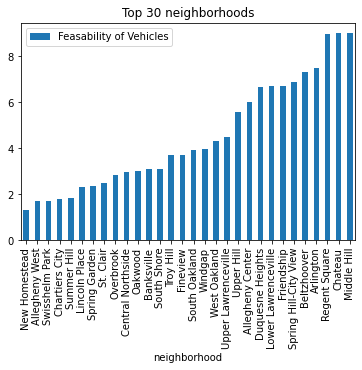

In [6]:
temp_df = main_df.head(30)
temp_df.plot.bar(x = 'neighborhood', y = 'Feasability of Vehicles', title = "Top 30 neighborhoods")

# We have determined New Homestead to be our best neighborhood by the metric of Feasability of Vehicles

As seen in the dataset, New Homestead has the least value for our metric. This is the best value because our metric comprises of bridge count, crime incidents, speed bump count, and traffic count. All of these sub-metrics were weighted accordingly:
* Police Incidents (25%)
* Traffic count (50%)
* Bridges (15%)
* Speed Hump (10%)

For all the sub-metrics, less is better. We want less police incidents in a neighborhood to feel safer to drive. We want less traffic so that it takes less time to drive as well. We want less bridges because bridges can constrict the traffic flow and indicate natural obstacles in transportation. Lastly, we want less speed humps because they slow down the traffic flow.

All of this indicates that our calculated metric score should be sorted from the least to greatest, as the least value of our metric actually has the best feasability of a vehicle.

# Conclusion


Reflect on how the data driven determination of “best neighborhood” is the same or different from your personal favorite neighborhood. Each member of the group should write their own response to this.

Jeremy: 
* I think that the neighborhood of New Homestead looks very homey. I think that from the pictures, the neighborhood is nice in terms that it is accessible but also the buildings aren’t very run down and that there seems like there are at least some things to do there. However, I would have to say that my personal favorite neighborhood is my own neighborhood from where I grew up in. I think that my neighborhood of Blue Bell is better because it is more flat. From the pictures, New Homestead is flat in some of its parts, but also has many hills, like other places in Pittsburgh. However, in my home neighborhood, it is flatter so it is much more enjoyable to drive around my neighborhood. Additionally, the population of my home neighborhood is around 40 times larger than New Homestead. Although this may indicate that the new homestead is quiet and peaceful, I think that I personally enjoy the social aspect of life, so I would like a neighborhood with a decent amount of people in it.


Kunal: 
* My favorite personal neighborhood is the one I grew up in. Like New Homestead, it is near the city, but it is in the suburbs. I lived in Loudoun County, which is near Washington DC, but is in the suburbs, like New Homestead. From what we gathered from our Feasibility to Drive, New Homestead seemed to be the best neighborhood to drive in. From my childhood neighborhood, this seems to pan out, as driving there did not seem to be a problem. One difference I would remark is that New Homestead is not as populous as Loudoun County, which might be a significant reason why we determined it to be the easiest neighborhood to drive in. However, the similarities in location in regards to a larger city and its general landscape correlate a lot with my personal favorite neighborhood, which is the one I grew up in.

Kevin:
* My personal favorite neighborhood in Pittsburgh is probably Squirrel Hill, rather than our data-driven determined best neighborhood of New Homestead. This is because I particuarly enjoy the many Asian establishments in the area, as well as the shops, which remind me of a much smaller-scale Chinatown of-sorts. The people around the area are also mainly fellow college students experiencing these places, which I enjoy being around. Though the feasibility of vehicles does not seem the worst in Squirrel Hill from anecdotal evidence, there are also less housing in the area than compared with New Homestead, based off pictures of New Homestead. Therefore, my personal favorite neighborhood is based off personal preferences that use metrics which are pretty difficult to define with collected data. However, through concrete data analysis, New Homestead still appears to be the best neighborhood in terms of feasibility of vehicles. 

Anish
* Having lived near Pittsburgh my whole life, I have a good idea of what the nicest neighborhoods look like in our area. Our data concluded that New Homestead is statistically the best neighborhood when it comes to ease of transportation via vehicles, and by actually traveling through the area, I can completely support this. In general, the area is very clean with lots of green space and doesn’t hold a lot of people in close quarters compared to the other more clustered neighborhoods in the Pittsburgh area. For example, in comparison to where Pitt is situated, in Oakland, New Homestead is much less populated on a daily basis on top of the lower amount of potential threats. For these reasons and many more, New Homestead comes out on top when it comes to ease of transportation, especially with vehicles.

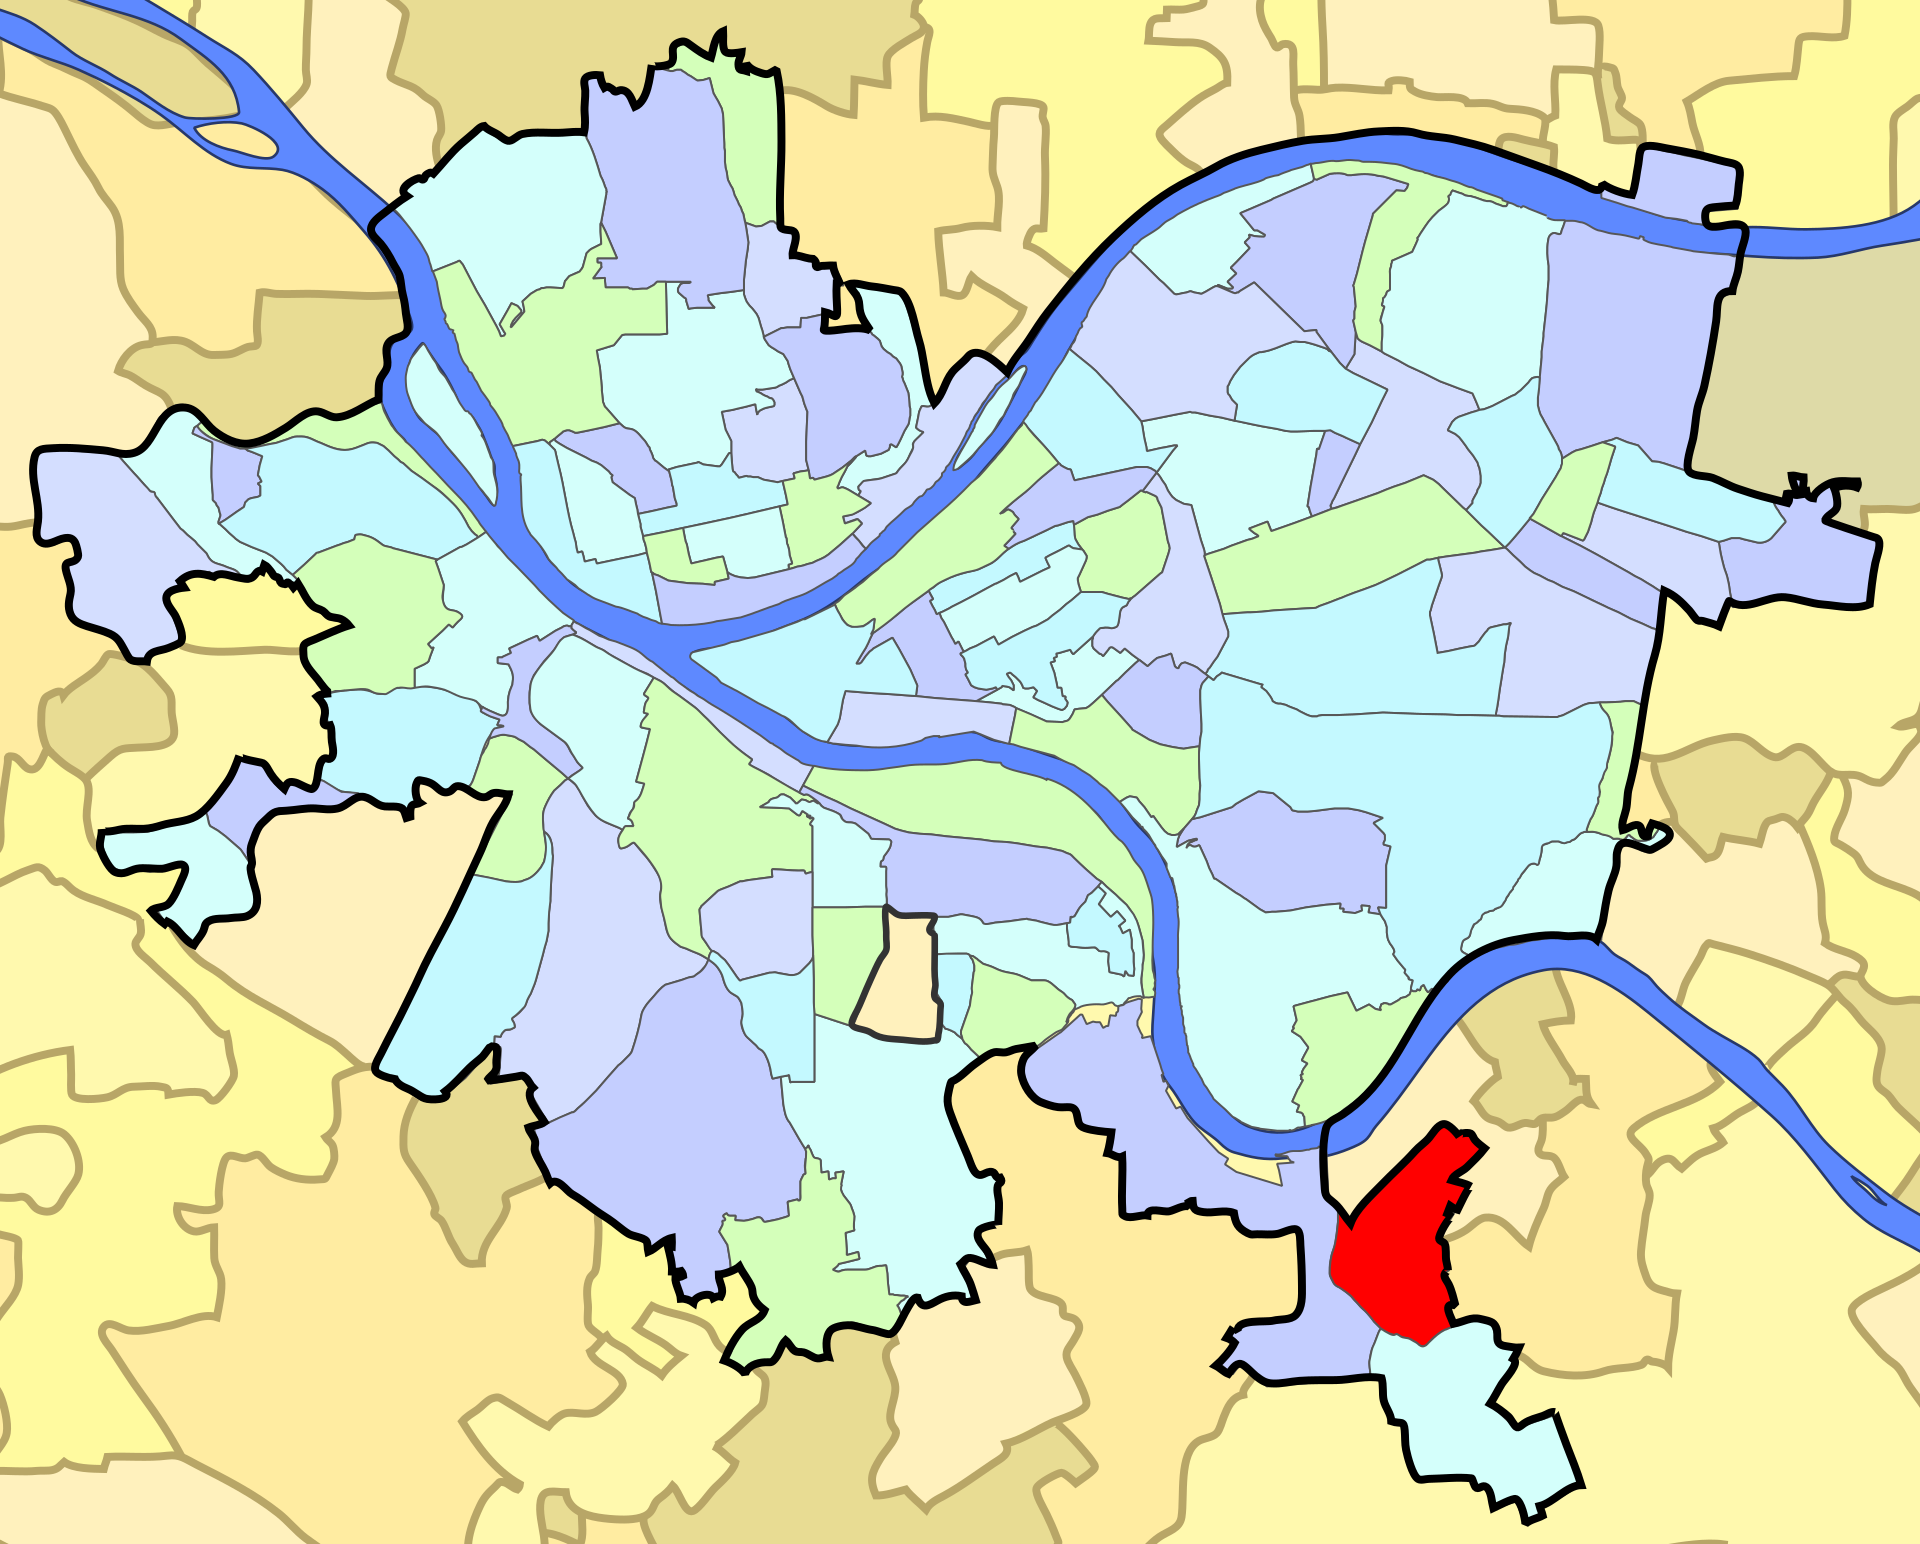

In [5]:
from IPython.display import Image
Image(filename='Pgh_locator_new_homestead.png')